# Attention is all you need
- In this colab notebook, I am going to re-implement the paper **Attention is all you need** from scratch

In [7]:
import math
import random
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

## Model Architecture

### Scaled Dot Product

![scaled_dot_product_attention](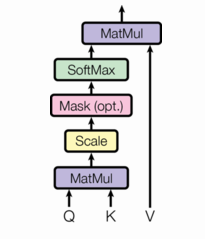 "Scaled Dot-Product Attention Block")

(source: https://arxiv.org/pdf/1706.03762.pdf)

$$
\text{Attention}(Q, K, V) = \text{softmax}(\frac{Q K^T}{\sqrt{d_k}}) V
$$



In [9]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self, scale):
    super(ScaledDotProductAttention, self).__init__()
    self.scale=scale

  def forward(self, query, key, value, mask=None):
    """
    query:(batch_size, n_heads, query_len, head_dim),
    key:(batch_size, n_heads, key_len, head_dim),
    value:(batch_size, n_heads, value_len, head_dim)
    """
    alignment_score=torch.matmul(query, key.transpose(-2, -1)) #(batch_size, n_heads, query_len, value_len)
    alignment_score=alignment_score/self.scale

    if mask is not None:
      alignment_score=alignment_score.masked_fill(mask==0, float('-inf'))

    attention_probab=F.softmax(alignment_score, dim=-1)

    output=torch.matmul(attention_probab, value)

    return output